Importing Libraries

In [3]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

Download Corpus, Tagset

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\saiki\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\saiki\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Extract Data from Brown Corpus

In [5]:
data = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

Spliting Data into n Batches

In [6]:
def split(data, n):
    k, m = divmod(len(data), n)
    
    split_data = []
    for i in range(n):
        split_data.append(data[i*k + min(i, m) : (i+1)*k + min(i+1, m)])
        
    return split_data


In [7]:
dataset = split(data, 5)

Seperate Data into test, train set based on index of test batch

In [8]:
def test_train(dataset, test_ind):
    train_sentences = []
    test_sentences = []

    for i in range(len(dataset)):
        if i != test_ind:
            for sentence in dataset[i]:
                train_sentences.append(sentence)
        else:
            for sentence in dataset[i]:
                test_sentences.append(sentence)

    return (train_sentences, test_sentences)

Getting Unique words, tags in a list of sentences

In [9]:
def uni_words_tags(train_sentences):
    tag_set = set()
    word_set = set()
    for sentence in train_sentences:
        for word, tag in sentence:
            tag_set.add(tag)
            word_set.add(word)
    return (tag_set, word_set)

Getting key in a dict from value

In [10]:
def get_key(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return -1

Generating 3 matrices based on training data

In [11]:
def gen_matrices(train_sentences):
    tag_set, word_set = uni_words_tags(train_sentences)
    tag_list = list(tag_set)
    word_list = list(word_set)
    
    tag_tag_matrix = np.zeros([len(tag_set), len(tag_set)])
    tag_word_matrix = np.zeros([len(tag_set), len(word_set)])
    start_tag_matrix = np.zeros([len(tag_set)])

    tag_dict = {}
    for i, tag in enumerate(tag_list):
        tag_dict[tag] = i

    word_dict = {}
    for i, word in enumerate(word_list):
        word_dict[word] = i

    for sentence in train_sentences:
        prev_tag = ''
        for key, (word, tag) in enumerate(sentence):
            if key == 0:
                start_tag_matrix[tag_dict[tag]] += 1
                prev_tag = tag
            else:
                tag_tag_matrix[tag_dict[prev_tag], tag_dict[tag]] += 1
                prev_tag = tag

    start_tag_count = np.sum(start_tag_matrix)
    start_tag_matrix /= start_tag_count

    tag_count = np.sum(tag_tag_matrix, axis=1)

    for t1 in tag_list:
        for t2 in tag_list:
            tag_tag_matrix[tag_dict[t2], tag_dict[t1]] += 1
            tag_tag_matrix[tag_dict[t2], tag_dict[t1]] /= (tag_count[tag_dict[t2]] + len(tag_list))

    for sentence in train_sentences:
        for word, tag in sentence:
            tag_word_matrix[tag_dict[tag], word_dict[word]] += 1

    tag_word_count = tag_word_matrix.sum(axis=1)

    for tag in tag_list:
        for word in word_list:
            tag_word_matrix[tag_dict[tag], word_dict[word]] += 1
            tag_word_matrix[tag_dict[tag], word_dict[word]] /= (tag_word_count[tag_dict[tag]] + len(word_list))
    
    return (start_tag_matrix, tag_tag_matrix, tag_word_matrix, tag_list, word_list)

Finding the accuracy from predictions and original output lists

In [12]:
def accuracy(test_res_tags, test_sent_tags):
    matched = 0
    total = 0
    for i in range(len(test_res_tags)):
        for j in range(len(test_res_tags[i])):
            if test_res_tags[i][j] == test_sent_tags[i][j]:
                matched += 1
            total += 1
    return (100*matched/total)

Main Viterbi Algorithm

In [13]:
def Viterbi_HMM(sentences, tag_tag_matrix, tag_word_matrix, start_tag_matrix, words, tags):
    test_result_tags = []
    tag_dict = {}
    word_dict = {}
    words_set = set(words)
    for i, tag in enumerate(tags):
        tag_dict[tag] = i

    for i, word in enumerate(words):
        word_dict[word] = i

    for sentence in sentences:
        if len(sentence) == 0:
            return []
        
        pr_tag_word_matrix = np.zeros([len(tags), len(sentence)])
        back_tracker = np.zeros([len(tags), len(sentence)])
        
        for i in range(len(tags)):
            if sentence[0] in words_set:
                w_index = word_dict[sentence[0]]
                pr_tag_word_matrix[i, 0] = start_tag_matrix[i] * tag_word_matrix[i, w_index]
            else:
                pr_tag_word_matrix[i, 0] = start_tag_matrix[i] * 1/len(tags)
            back_tracker[i, 0] = -1
                

        for s in range(1, len(sentence)):
            for i in range(len(tags)):
                tr_matrix = np.multiply(pr_tag_word_matrix[:, s - 1], tag_tag_matrix[:, i])
                max_tag_ind = np.argmax(tr_matrix)
                back_tracker[i, s] = max_tag_ind
                if sentence[s] in words_set:
                    w_index = word_dict[sentence[s]]
                    pr_tag_word_matrix[i, s] = tr_matrix[max_tag_ind] * tag_word_matrix[i, w_index]
                else:
                    pr_tag_word_matrix[i, s] = tr_matrix[max_tag_ind] * 1/len(words)
                    
                        
        tag_index = np.zeros([len(sentence)])
        tag_index[-1] = np.argmax(pr_tag_word_matrix[:, len(sentence) - 1])
        for i in reversed(range(len(sentence) - 1)):
            tag_index[i] = back_tracker[int(tag_index[i + 1]), int(i + 1)]
        temp = []
        for i in tag_index:
            temp.append(get_key(tag_dict, i))
        test_result_tags.append(temp)
    return test_result_tags


Generating Confusion Matrix

In [14]:
def gen_confusion_matrix(tags, test_sent_tags, test_result_tags):
    tag_dict = {}
    for i, tag in enumerate(tags):
        tag_dict[tag] = i

    confusion_matrix = np.zeros((len(tags), len(tags)))
    for i in range(len(test_sent_tags)):
        for j in range(len(test_sent_tags[i])):
            confusion_matrix[tag_dict[test_sent_tags[i][j]]
                             ][tag_dict[test_result_tags[i][j]]] += 1

    return confusion_matrix


F score values generation

In [15]:
def get_F_matrix(precision_matrix, recall_matrix, confusion_matrix, tags, beta):
    F_matrix = np.zeros((1, len(tags)))
    tag_dict = {}
    for i, tag in enumerate(tags):
        tag_dict[tag] = i


    # (1+b^2) p*r/((b^2)p+r)
    for tag in tags:
        F_matrix[0][tag_dict[tag]] = ((1 + beta**2)*precision_matrix[0][tag_dict[tag]]*recall_matrix[0][tag_dict[tag]])/(
            (beta**2)*precision_matrix[0][tag_dict[tag]] + recall_matrix[0][tag_dict[tag]])

    return F_matrix


Results

In [16]:
def results(tags, confusion_matrix):
    tag_dict = {}
    for i, tag in enumerate(tags):
        tag_dict[tag] = i

    precision_matrix = np.zeros((1, len(tags)))
    recall_matrix = np.zeros((1, len(tags)))

    for tag in tags:
        precision_matrix[0][tag_dict[tag]] = confusion_matrix[tag_dict[tag]
                                                              ][tag_dict[tag]]/np.sum(confusion_matrix, axis=0)[tag_dict[tag]]
        recall_matrix[0][tag_dict[tag]] = confusion_matrix[tag_dict[tag]
                                                           ][tag_dict[tag]]/(np.sum(confusion_matrix, axis=1)[tag_dict[tag]])

    F1_matrix = get_F_matrix(
        precision_matrix, recall_matrix, confusion_matrix, tags, 1)
    F2_matrix = get_F_matrix(
        precision_matrix, recall_matrix, confusion_matrix, tags, 2)
    F_0_5_matrix = get_F_matrix(
        precision_matrix, recall_matrix, confusion_matrix, tags, 0.5)

    precision_matrix_df = pd.DataFrame(
        precision_matrix, index=[0], columns=list(tags))
    recall_matrix_df = pd.DataFrame(
        recall_matrix, index=[0], columns=list(tags))
    F1_matrix_df = pd.DataFrame(F1_matrix, index=[0], columns=list(tags))
    F2_matrix_df = pd.DataFrame(F2_matrix, index=[0], columns=list(tags))
    F_0_5_matrix_df = pd.DataFrame(
        F_0_5_matrix, index=[0], columns=list(tags))
    print("Precision Matrix :")
    display(precision_matrix_df)
    print("Recall Matrix :")
    display(recall_matrix_df)
    print("F1 Matrix :")
    display(F1_matrix_df)
    print("F2 Matrix :")
    display(F2_matrix_df)
    print("F0.5 Matrix :")
    display(F_0_5_matrix_df)
    return (precision_matrix, recall_matrix, F1_matrix, F2_matrix, F_0_5_matrix)


  0%|          | 0/5 [00:00<?, ?it/s]

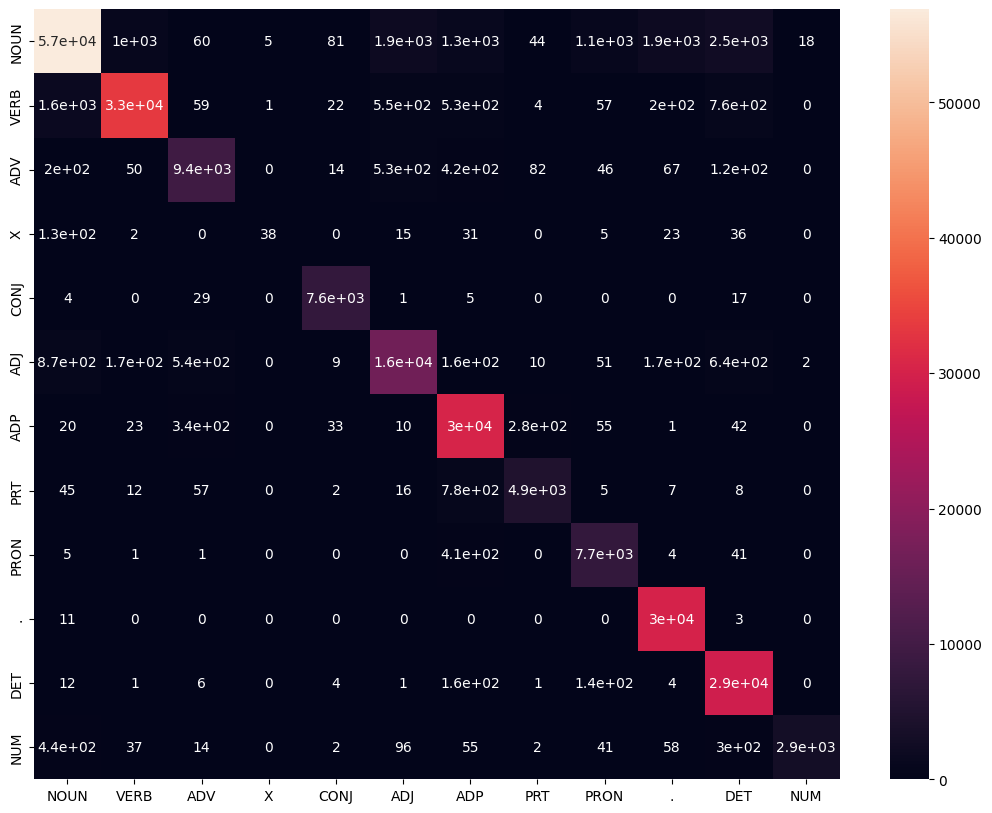

Precision Matrix :


,NOUN,VERB,ADV,X,CONJ,ADJ,ADP,PRT,PRON,.,DET,NUM
0,0.945116,0.961855,0.8958,0.863636,0.978515,0.841384,0.887272,0.920121,0.837934,0.925075,0.866643,0.993211


Recall Matrix :


,NOUN,VERB,ADV,X,CONJ,ADJ,ADP,PRT,PRON,.,DET,NUM
0,0.85161,0.899214,0.861179,0.135231,0.992691,0.861729,0.974233,0.839406,0.943442,0.999535,0.988864,0.736286


F1 Matrix :


,NOUN,VERB,ADV,X,CONJ,ADJ,ADP,PRT,PRON,.,DET,NUM
0,0.89593,0.92948,0.878149,0.233846,0.985552,0.851435,0.928722,0.877912,0.887564,0.960864,0.923728,0.845665


F2 Matrix :


,NOUN,VERB,ADV,X,CONJ,ADJ,ADP,PRT,PRON,.,DET,NUM
0,0.868801,0.911081,0.867888,0.162671,0.989823,0.857581,0.955504,0.854396,0.920267,0.983699,0.961738,0.776457


F0.5 Matrix :


,NOUN,VERB,ADV,X,CONJ,ADJ,ADP,PRT,PRON,.,DET,NUM
0,0.924808,0.948638,0.888655,0.415755,0.981318,0.845375,0.9034,0.90276,0.857105,0.939066,0.888609,0.928417


 20%|██        | 1/5 [00:10<00:40, 10.23s/it]

Fold Precision Value:  0.9163768160307615
Fold Recall Value:  0.9134126857325451
Fold F1 Score:  0.9124186317460119


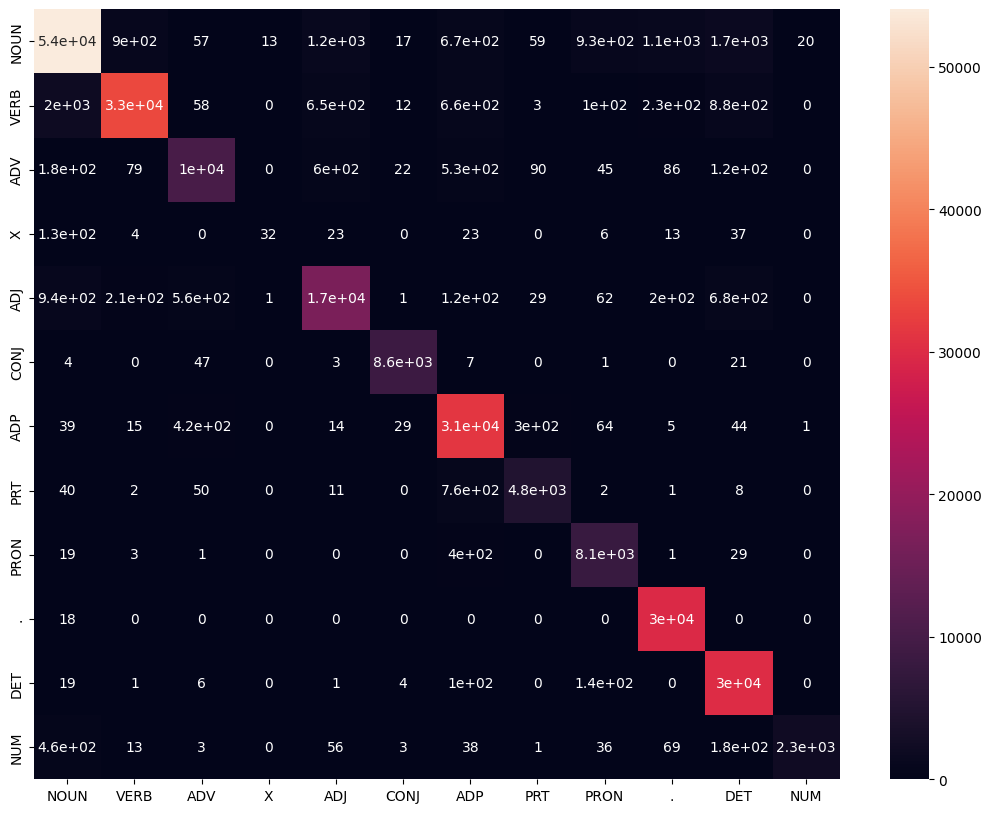

Precision Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.933822,0.964512,0.89537,0.695652,0.866615,0.989822,0.904591,0.909314,0.8545,0.946586,0.891326,0.990781


Recall Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.890595,0.879737,0.853687,0.121212,0.857194,0.990395,0.971185,0.846614,0.946657,0.999395,0.991212,0.724326


F1 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.911696,0.920176,0.874032,0.206452,0.861879,0.990108,0.936706,0.876845,0.898221,0.972274,0.938619,0.836856


F2 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.898918,0.895478,0.86171,0.145191,0.859062,0.99028,0.957093,0.858453,0.926669,0.988367,0.969483,0.7655


F0.5 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.924844,0.946275,0.886711,0.357143,0.864714,0.989936,0.917169,0.896042,0.871467,0.956696,0.909659,0.922882


 40%|████      | 2/5 [00:20<00:29,  9.98s/it]

Fold Precision Value:  0.9229976380323516
Fold Recall Value:  0.9217171717171717
Fold F1 Score:  0.9207675757745737


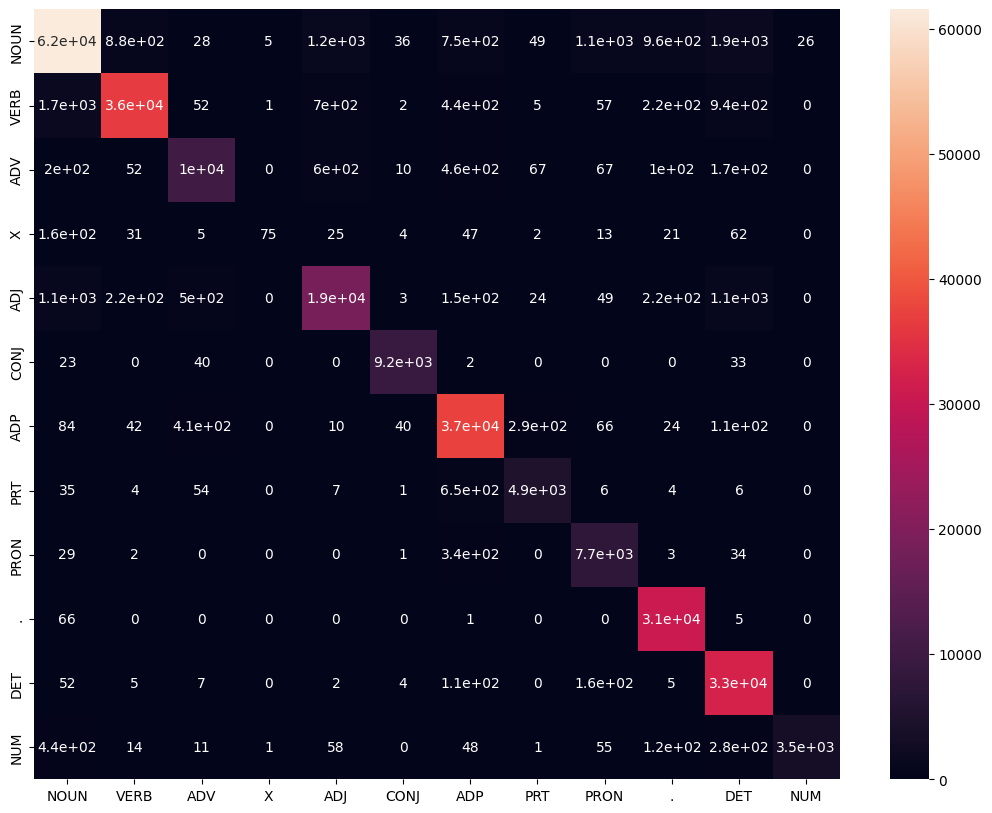

Precision Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.940937,0.966993,0.903526,0.914634,0.876115,0.989164,0.925886,0.917739,0.83384,0.94815,0.87665,0.992584


Recall Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.899284,0.8991,0.857249,0.168539,0.847884,0.989483,0.972041,0.865435,0.949808,0.997656,0.989392,0.773677


F1 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.919639,0.931811,0.87978,0.28463,0.861769,0.989323,0.948402,0.89082,0.888054,0.972273,0.929615,0.869565


F2 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.907317,0.911905,0.866121,0.201396,0.853384,0.989419,0.962445,0.875414,0.924104,0.987346,0.964582,0.809378


F0.5 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.932301,0.952606,0.893875,0.485123,0.87032,0.989228,0.934763,0.906779,0.854711,0.957654,0.897095,0.939423


 60%|██████    | 3/5 [00:30<00:20, 10.20s/it]

Fold Precision Value:  0.9276748461129408
Fold Recall Value:  0.9260325695239698
Fold F1 Score:  0.9251778848289104


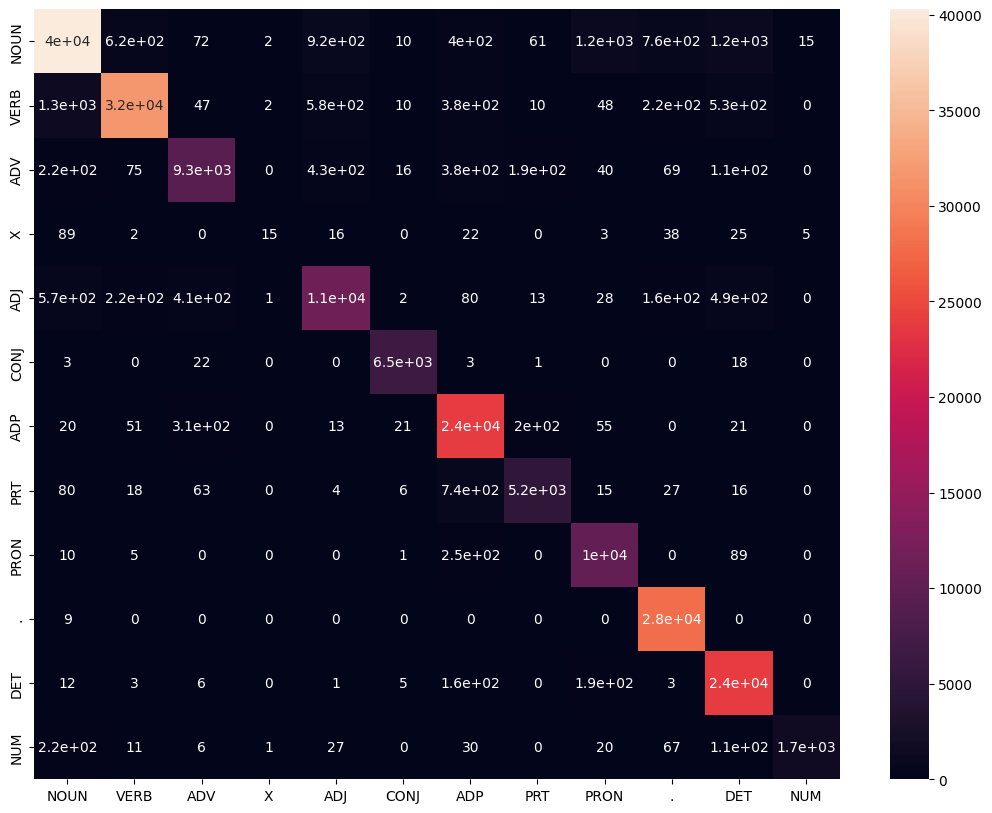

Precision Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.940466,0.969312,0.909224,0.714286,0.849502,0.98921,0.907189,0.916152,0.864322,0.954304,0.900521,0.988571


Recall Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.88369,0.909559,0.859714,0.069767,0.850657,0.992831,0.971742,0.843217,0.967107,0.999678,0.984331,0.781391


F1 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.911195,0.938485,0.883776,0.127119,0.850079,0.991017,0.938356,0.878173,0.91283,0.976464,0.940562,0.872856


F2 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.89449,0.920913,0.86918,0.085131,0.850426,0.992105,0.958107,0.85686,0.94464,0.990261,0.966343,0.815576


F0.5 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.928535,0.956741,0.898871,0.250836,0.849733,0.989932,0.919404,0.900573,0.883093,0.963047,0.916121,0.938789


 80%|████████  | 4/5 [00:39<00:09,  9.86s/it]

Fold Precision Value:  0.928285426191534
Fold Recall Value:  0.9271409857936281
Fold F1 Score:  0.9263028918957571


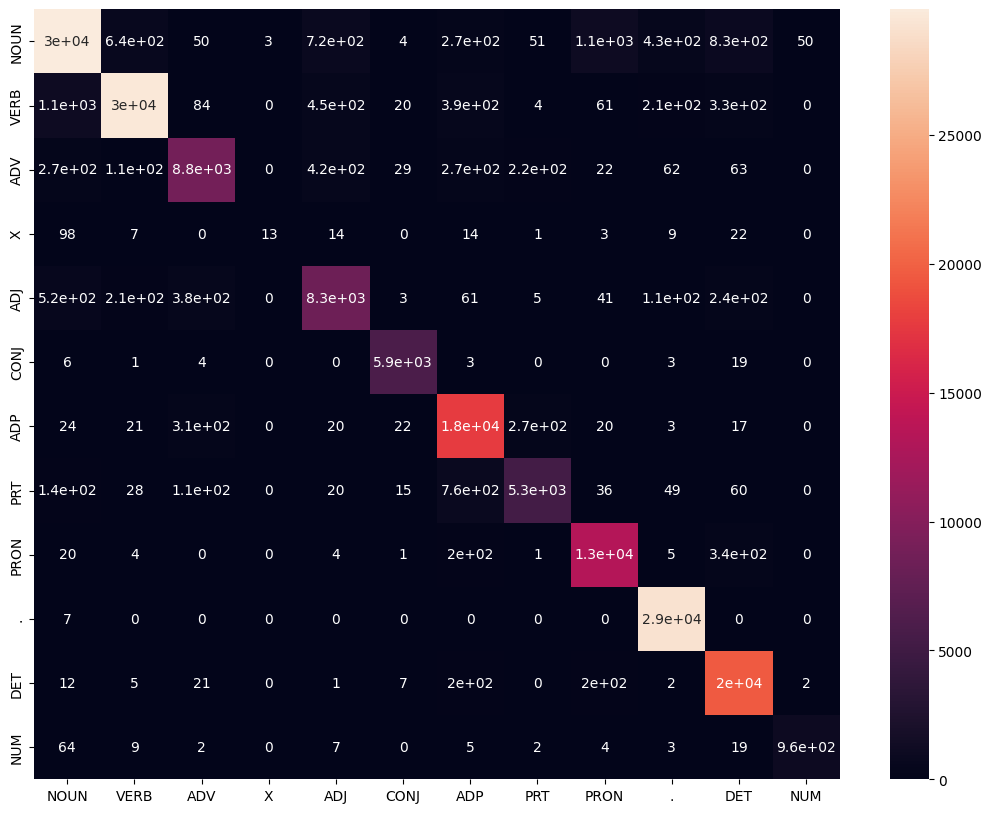

Precision Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.928987,0.966259,0.901889,0.8125,0.833551,0.983275,0.89039,0.905373,0.898571,0.970462,0.909843,0.948464


Recall Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.878019,0.917005,0.857753,0.071823,0.841502,0.993974,0.961538,0.812375,0.958285,0.999759,0.977434,0.892724


F1 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.902784,0.940988,0.879267,0.13198,0.837508,0.988596,0.924598,0.856357,0.927468,0.984893,0.942428,0.91975


F2 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.88776,0.92645,0.866231,0.087838,0.8399,0.991816,0.946414,0.829414,0.945716,0.993759,0.963124,0.903342


F0.5 Matrix :


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.918325,0.955989,0.892702,0.265306,0.835129,0.985397,0.903765,0.885108,0.909911,0.976183,0.922603,0.936766


100%|██████████| 5/5 [00:49<00:00,  9.90s/it]

Fold Precision Value:  0.928140128247376
Fold Recall Value:  0.9276106331177774
Fold F1 Score:  0.9268080599475573


In [17]:
fold_p_values = []
fold_r_values = []
fold_f1_values = []
fold_f2_values = []
fold_f_0_5_values = []
con_mats = []
p_mats = []
r_mats = []
f1_mats = []

for i in tqdm(range(5)):
    train_sentences, test_sentences = test_train(dataset, i)
    start_tag_matrix, tag_tag_matrix, tag_word_matrix, tags, words = gen_matrices(
        train_sentences)
    tags, words = uni_words_tags(train_sentences)
    test_sent_words = []
    test_sent_tags = []
    test_res_tags = []
    for sentence in test_sentences:
        temp_word = []
        temp_tag = []
        for word, tag in sentence:
            temp_word.append(word)
            temp_tag.append(tag)
        test_sent_words.append(temp_word)
        test_sent_tags.append(temp_tag)
    test_result_tags = Viterbi_HMM(
        test_sent_words, tag_tag_matrix, tag_word_matrix, start_tag_matrix, words, tags)
    confusion_matrix = gen_confusion_matrix(
        tags, test_sent_tags, test_result_tags)

    confusion_matrix_df = pd.DataFrame(
        confusion_matrix, index=list(tags), columns=list(tags))
    plt.figure(figsize=(13, 10))
    confusion_figure = sns.heatmap(
        confusion_matrix, annot=True, xticklabels=tags, yticklabels=tags)
    plt.show(confusion_figure)
    precision_matrix, recall_matrix, F1_matrix, F2_matrix, F_0_5_matrix = results(
        tags, confusion_matrix)

    con_mats.append(confusion_matrix)
    p_mats.append(precision_matrix)
    r_mats.append(recall_matrix)
    f1_mats.append(F1_matrix)

    fold_precision = np.sum(np.multiply(
        precision_matrix, confusion_matrix.sum(axis=1)))/confusion_matrix.sum()
    fold_recall = np.sum(np.multiply(
        recall_matrix, confusion_matrix.sum(axis=1)))/confusion_matrix.sum()
    fold_f1 = np.sum(np.multiply(
        F1_matrix, confusion_matrix.sum(axis=1)))/confusion_matrix.sum()
    fold_f2 = np.sum(np.multiply(
        F2_matrix, confusion_matrix.sum(axis=1)))/confusion_matrix.sum()
    fold_f_0_5 = np.sum(np.multiply(
        F_0_5_matrix, confusion_matrix.sum(axis=1)))/confusion_matrix.sum()

    fold_p_values.append(fold_precision)
    fold_r_values.append(fold_recall)
    fold_f1_values.append(fold_f1)
    fold_f2_values.append(fold_f2)
    fold_f_0_5_values.append(fold_f_0_5)

    print("Fold Precision Value: ", fold_precision)
    print("Fold Recall Value: ", fold_recall)
    print("Fold F1 Score: ", fold_f1)
    # print('Accuracy: ', accuracy(test_result_tags, test_sent_tags))


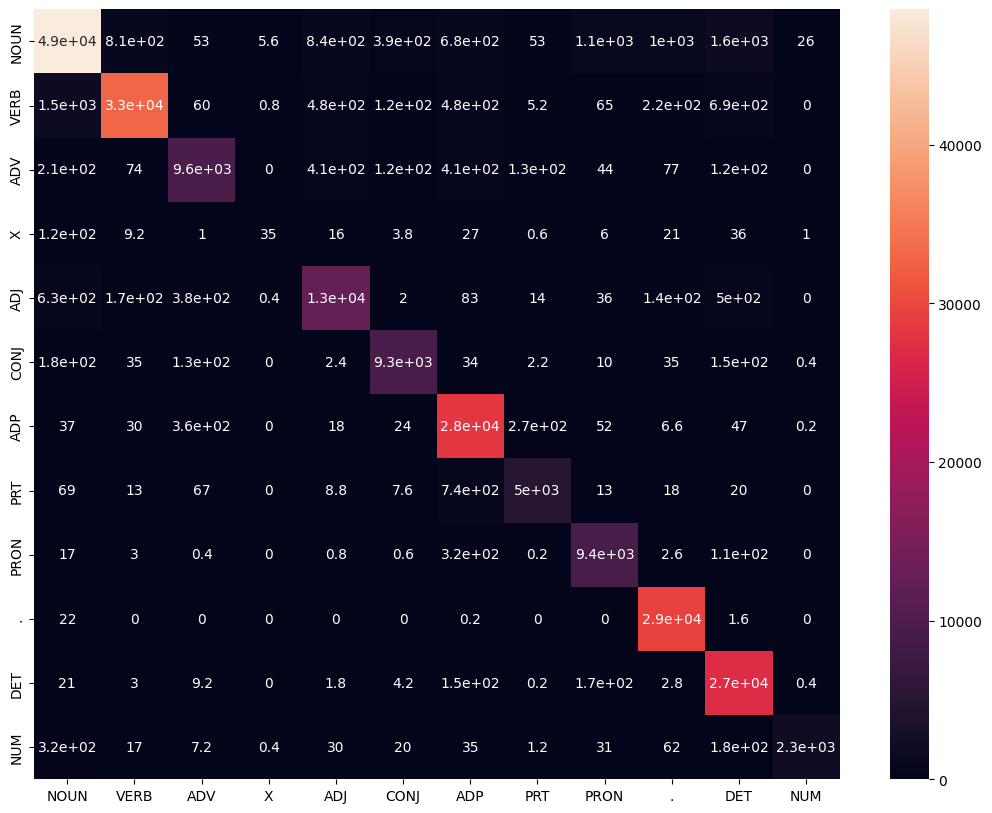

Overall Precision Value:  0.9246949709229927
Overall Recall Value:  0.9231828091770184
Overall F1 Score: 0.922295008838562
Overall F2 Score: 0.9224972500028198
Overall F 0.5 Score: 0.9231721425673968
Overall Tag Precision: 


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.937866,0.965786,0.901162,0.800142,0.88086,0.958571,0.903066,0.91374,0.857833,0.948915,0.888996,0.982722


Overall Tag Recall: 


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.88064,0.900923,0.857917,0.113315,0.877986,0.965682,0.970148,0.841409,0.95306,0.999205,0.986247,0.781681


Overall Tag F1: 


,NOUN,VERB,ADV,X,ADJ,CONJ,ADP,PRT,PRON,.,DET,NUM
0,0.908249,0.932188,0.879001,0.196805,0.879357,0.962096,0.935357,0.876021,0.902827,0.973354,0.93499,0.868938


In [18]:
avg_confusion_matrix = np.mean( np.array([mat for mat in con_mats]), axis=0 )
avg_tag_p_matrix = np.mean( np.array([mat for mat in p_mats]), axis=0)
avg_tag_r_matrix = np.mean( np.array([mat for mat in r_mats]), axis=0)
avg_tag_f1_matrix = np.mean( np.array([mat for mat in f1_mats]), axis=0)

plt.figure(figsize=(13, 10))
avg_confusion_figure = sns.heatmap(
    avg_confusion_matrix, annot=True, xticklabels=tags, yticklabels=tags)
plt.show(avg_confusion_figure)

avg_tag_p_df = pd.DataFrame(
        avg_tag_p_matrix, index=[0], columns=list(tags))
avg_tag_r_df = pd.DataFrame(
        avg_tag_r_matrix, index=[0], columns=list(tags))
avg_tag_f1_df = pd.DataFrame(
        avg_tag_f1_matrix, index=[0], columns=list(tags))

print("Overall Precision Value: ", np.mean(fold_p_values))
print("Overall Recall Value: ", np.mean(fold_r_values))
print("Overall F1 Score:", np.mean(fold_f1_values))
print("Overall F2 Score:", np.mean(fold_f2_values))
print("Overall F 0.5 Score:", np.mean(fold_f_0_5_values))

print("Overall Tag Precision: ")
display(avg_tag_p_df)
print("Overall Tag Recall: ")
display(avg_tag_r_df)
print("Overall Tag F1: ")
display(avg_tag_f1_df)

In [37]:
new_sentence = [['I','love','you']]
new_tags = Viterbi_HMM(new_sentence,tag_tag_matrix,tag_word_matrix,start_tag_matrix,words, tags)
print(new_tags)

[['PRON', 'VERB', 'PRON']]


In [36]:
import pickle

with open('./output/tag_tag_matrix.pkl', 'wb') as file:
    pickle.dump(tag_tag_matrix, file)

with open('./output/tag_word_matrix.pkl', 'wb') as file:
    pickle.dump(tag_word_matrix, file)

with open('./output/start_tag_matrix.pkl', 'wb') as file:
    pickle.dump(start_tag_matrix, file)

tag_dict = {}
word_dict = {}
for i, tag in enumerate(tags):
    tag_dict[tag] = i

for i, word in enumerate(words):
    word_dict[word] = i

with open('./output/word_dict.pkl', 'wb') as file:
    pickle.dump(word_dict, file)

with open('./output/tag_dict.pkl', 'wb') as file:
    pickle.dump(tag_dict, file)

with open('./output/words.pkl', 'wb') as file:
    pickle.dump(words, file)

with open('./output/tags.pkl', 'wb') as file:
    pickle.dump(tags, file)

In [34]:
print(list(words)[-1])

fifteen
